In [ ]:
# !pip install holidays

# Dataset info.
### train 데이터 : 2019년 01월 01일부터 2023년 03월 03일까지의 유통된 품목의 가격 데이터
- item: 품목 코드
> - 🍊 TG : 감귤
> - 🥦 BC : 브로콜리
> - RD : 무
> - 🥕 CR : 당근
> - 🥬 CB : 양배추
- corporation : 유통 법인 코드
- 법인 A부터 F 존재
- location : 지역 코드
> - J : 제주도 제주시
> - S : 제주도 서귀포시
- supply(kg) : 유통된 물량, kg 단위
- price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위

In [ ]:
import pandas as pd
import numpy as np
import datetime
import holidays
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rc('font', family='NanumGothic')

from sklearn.preprocessing import LabelEncoder

# Loading data

In [62]:
train = pd.read_csv('./data/train.csv', )
test = pd.read_csv('./data/test.csv')

In [3]:
train.head()

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


# EDA

In [4]:
train.isnull().sum()

ID             0
timestamp      0
item           0
corporation    0
location       0
supply(kg)     0
price(원/kg)    0
dtype: int64

### 품목 별 가격 분포

<Axes: xlabel='item', ylabel='price(원/kg)'>

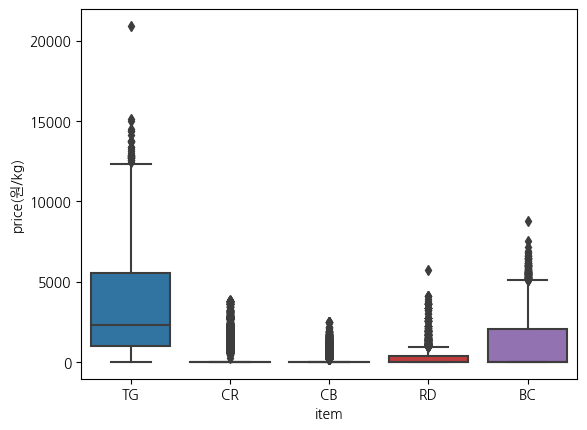

In [5]:
sns.boxplot(x='item',y='price(원/kg)',data=train)

### 법인 별 가격 분포

<Axes: xlabel='corporation', ylabel='price(원/kg)'>

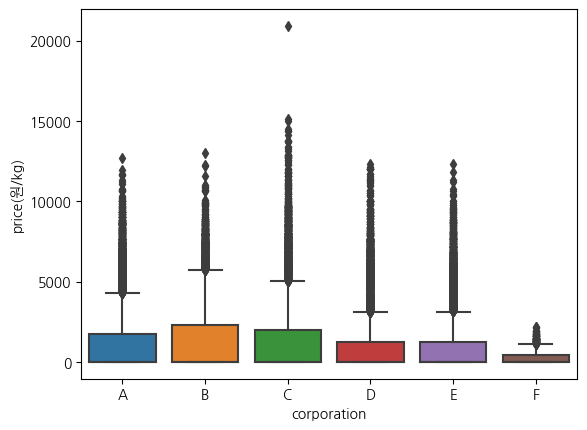

In [6]:
sns.boxplot(x='corporation',y='price(원/kg)',data=train)

### location별 가격 분포

<Axes: xlabel='location', ylabel='price(원/kg)'>

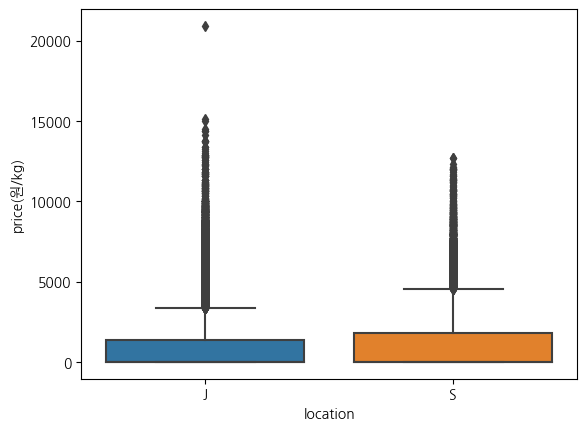

In [7]:
sns.boxplot(x='location',y='price(원/kg)',data=train)

# Preprocessing

In [8]:
def preprocessing(df):
    df['timestamp']=pd.to_datetime(df['timestamp'])
    
    #timestamp -> year, month, day
    
    df['year']=df['timestamp'].dt.year
    df['month']=df['timestamp'].dt.month
    df['day']=df['timestamp'].dt.day
    df['dayofweek']=df['timestamp'].dt.dayofweek # 요일 추가
    df['dayofyear']=df['timestamp'].dt.dayofyear
    df['week_of_year']=df['timestamp'].dt.isocalendar().week # 몇 주인지 추가
    
    # ID의 정보는 item-corporation-location이므로 중복으로 넣어줄 필요 없음
    df.drop(columns = ['ID'],axis=1,inplace=True) 
    
    # location encoding
    location_mapping={'J':0,'S':1}
    df['location'] = df['location'].map(location_mapping)  
    
    # corporation encoding
    corporation_mapping={'A':1,'B':2,'C':3,'D':4,'E':5,'F':6}
    df['corporation'] = df['corporation'].map(corporation_mapping)
    
    
    # 편의상 변경
    df.rename(columns={'price(원/kg)':'price'},inplace=True)
    
    
    # holiday(공휴일) 컬럼 생성
    def isHoliday(x):
        kr_holiday=holidays.KR()
        
        if x in kr_holiday:
            return 1
        else:
            return 0    
    df['holiday'] = df['timestamp'].map(lambda x:isHoliday(x))
    
    
    # 품목 별로 데이터프레임 나누기
    df_tg = df[df['item']=='TG'].copy().reset_index(drop=True)
    df_bc = df[df['item']=='BC'].copy().reset_index(drop=True)
    df_rd = df[df['item']=='RD'].copy().reset_index(drop=True)
    df_cr = df[df['item']=='CR'].copy().reset_index(drop=True)
    df_cb = df[df['item']=='CB'].copy().reset_index(drop=True)
    
    return df_tg,df_bc,df_rd,df_cr,df_cb

In [63]:
# train 데이터 기본 전처리
df_tg,df_bc,df_rd,df_cr,df_cb = preprocessing(train)

In [43]:
print('감귤 데이터 개수:',df_tg.shape[0])
print('브로콜리 데이터 개수:',df_bc.shape[0])
print('무 데이터 개수:',df_rd.shape[0])
print('당근 데이터 개수:',df_cr.shape[0])
print('양배추 데이터 개수:',df_cb.shape[0])

감귤 데이터 개수: 15230
브로콜리 데이터 개수: 13707
무 데이터 개수: 12184
당근 데이터 개수: 10661
양배추 데이터 개수: 7615


In [18]:
tg_min_date = df_tg['timestamp'].min()
tg_max_date = df_tg['timestamp'].max()
display(f"감귤 데이터 기간 : {tg_min_date} ~ {tg_max_date}")

bc_min_date = df_bc['timestamp'].min()
bc_max_date = df_bc['timestamp'].max()
display(f"브로콜리 데이터 기간 : {bc_min_date} ~ {bc_max_date}")

rd_min_date = df_rd['timestamp'].min()
rd_max_date = df_rd['timestamp'].max()
display(f"무 데이터 기간 : {rd_min_date} ~ {rd_max_date}")

cr_min_date = df_cr['timestamp'].min()
cr_max_date = df_cr['timestamp'].max()
display(f"당근 데이터 기간 : {cr_min_date} ~ {cr_max_date}")

cb_min_date = df_cb['timestamp'].min()
cb_max_date = df_cb['timestamp'].max()
display(f"양배추 데이터 기간 : {cb_min_date} ~ {cb_max_date}")

'감귤 데이터 기간 : 2019-01-01 00:00:00 ~ 2023-03-03 00:00:00'

'브로콜리 데이터 기간 : 2019-01-01 00:00:00 ~ 2023-03-03 00:00:00'

'무 데이터 기간 : 2019-01-01 00:00:00 ~ 2023-03-03 00:00:00'

'당근 데이터 기간 : 2019-01-01 00:00:00 ~ 2023-03-03 00:00:00'

'양배추 데이터 기간 : 2019-01-01 00:00:00 ~ 2023-03-03 00:00:00'

In [20]:
df_tg.head()

,timestamp,item,corporation,location,supply(kg),price,year,month,day,dayofweek,dayofyear,week_of_year,holiday
0,2019-01-01,TG,1,0,0.0,0.0,2019,1,1,1,1,1,1
1,2019-01-02,TG,1,0,0.0,0.0,2019,1,2,2,2,1,0
2,2019-01-03,TG,1,0,60601.0,1728.0,2019,1,3,3,3,1,0
3,2019-01-04,TG,1,0,25000.0,1408.0,2019,1,4,4,4,1,0
4,2019-01-05,TG,1,0,32352.0,1250.0,2019,1,5,5,5,1,0


In [21]:
df_bc.head()

,timestamp,item,corporation,location,supply(kg),price,year,month,day,dayofweek,dayofyear,week_of_year,holiday
0,2019-01-01,BC,1,0,0.0,0.0,2019,1,1,1,1,1,1
1,2019-01-02,BC,1,0,0.0,0.0,2019,1,2,2,2,1,0
2,2019-01-03,BC,1,0,7616.0,2559.0,2019,1,3,3,3,1,0
3,2019-01-04,BC,1,0,7488.0,2425.0,2019,1,4,4,4,1,0
4,2019-01-05,BC,1,0,10408.0,2097.0,2019,1,5,5,5,1,0


In [22]:
df_rd.head()

,timestamp,item,corporation,location,supply(kg),price,year,month,day,dayofweek,dayofyear,week_of_year,holiday
0,2019-01-01,RD,1,0,0.0,0.0,2019,1,1,1,1,1,1
1,2019-01-02,RD,1,0,0.0,0.0,2019,1,2,2,2,1,0
2,2019-01-03,RD,1,0,37060.0,367.0,2019,1,3,3,3,1,0
3,2019-01-04,RD,1,0,19260.0,460.0,2019,1,4,4,4,1,0
4,2019-01-05,RD,1,0,32140.0,402.0,2019,1,5,5,5,1,0


In [23]:
df_cr.head()

,timestamp,item,corporation,location,supply(kg),price,year,month,day,dayofweek,dayofyear,week_of_year,holiday
0,2019-01-01,CR,1,0,0.0,0.0,2019,1,1,1,1,1,1
1,2019-01-02,CR,1,0,0.0,0.0,2019,1,2,2,2,1,0
2,2019-01-03,CR,1,0,0.0,0.0,2019,1,3,3,3,1,0
3,2019-01-04,CR,1,0,10240.0,1141.0,2019,1,4,4,4,1,0
4,2019-01-05,CR,1,0,8680.0,1133.0,2019,1,5,5,5,1,0


In [24]:
df_cb.head()

,timestamp,item,corporation,location,supply(kg),price,year,month,day,dayofweek,dayofyear,week_of_year,holiday
0,2019-01-01,CB,1,0,0.0,0.0,2019,1,1,1,1,1,1
1,2019-01-02,CB,1,0,0.0,0.0,2019,1,2,2,2,1,0
2,2019-01-03,CB,1,0,0.0,0.0,2019,1,3,3,3,1,0
3,2019-01-04,CB,1,0,0.0,0.0,2019,1,4,4,4,1,0
4,2019-01-05,CB,1,0,4112.0,374.0,2019,1,5,5,5,1,0


# 로그 수익률 추가 (Add log return)

In [76]:
def log_price(df):
    tmp=df.copy()
    tmp['price']=tmp['price'].replace(0,1)
    tmp['price_log'] = np.log(tmp['price'])
    df['diff'] = (tmp['price_log'] - tmp['price_log'].shift(1)).shift(-1)
    
    return df

In [77]:
df_tg=log_price(df_tg)
df_tg.head()

,timestamp,item,corporation,location,supply(kg),price,year,month,day,dayofweek,dayofyear,week_of_year,holiday,diff
0,2019-01-03,TG,1,0,60601.0,1728.0,2019,1,3,3,3,1,0,-0.204663
1,2019-01-04,TG,1,0,25000.0,1408.0,2019,1,4,4,4,1,0,-0.118937
2,2019-01-05,TG,1,0,32352.0,1250.0,2019,1,5,5,5,1,0,0.000000
3,2019-01-06,TG,1,0,32352.0,1250.0,2019,1,6,6,6,1,0,0.164715
4,2019-01-07,TG,1,0,44995.0,1474.0,2019,1,7,0,7,2,0,-0.105737


In [78]:
df_bc=log_price(df_bc)
df_bc.head()

,timestamp,item,corporation,location,supply(kg),price,year,month,day,dayofweek,dayofyear,week_of_year,holiday,diff
0,2019-01-03,BC,1,0,7616.0,2559.0,2019,1,3,3,3,1,0,-0.053763
1,2019-01-04,BC,1,0,7488.0,2425.0,2019,1,4,4,4,1,0,-0.145259
2,2019-01-05,BC,1,0,10408.0,2097.0,2019,1,5,5,5,1,0,0.000000
3,2019-01-06,BC,1,0,10408.0,2097.0,2019,1,6,6,6,1,0,-0.146002
4,2019-01-07,BC,1,0,11320.0,1812.0,2019,1,7,0,7,2,0,0.097664


In [79]:
df_rd=log_price(df_rd)
df_rd.head()

,timestamp,item,corporation,location,supply(kg),price,year,month,day,dayofweek,dayofyear,week_of_year,holiday,diff
0,2019-01-03,RD,1,0,37060.0,367.0,2019,1,3,3,3,1,0,0.225315
1,2019-01-04,RD,1,0,19260.0,460.0,2019,1,4,4,4,1,0,-0.134461
2,2019-01-05,RD,1,0,32140.0,402.0,2019,1,5,5,5,1,0,0.000000
3,2019-01-06,RD,1,0,32140.0,402.0,2019,1,6,6,6,1,0,-0.149612
4,2019-01-07,RD,1,0,58860.0,346.0,2019,1,7,0,7,2,0,-0.071672


In [80]:
df_cr=log_price(df_cr)
df_cr.head()

,timestamp,item,corporation,location,supply(kg),price,year,month,day,dayofweek,dayofyear,week_of_year,holiday,diff
0,2019-01-04,CR,1,0,10240.0,1141.0,2019,1,4,4,4,1,0,-0.007030
1,2019-01-05,CR,1,0,8680.0,1133.0,2019,1,5,5,5,1,0,0.000000
2,2019-01-06,CR,1,0,8680.0,1133.0,2019,1,6,6,6,1,0,0.000000
3,2019-01-07,CR,1,0,8680.0,1133.0,2019,1,7,0,7,2,0,0.000000
4,2019-01-08,CR,1,0,8680.0,1133.0,2019,1,8,1,8,2,0,-0.018692


In [81]:
df_cb=log_price(df_cb)
df_cb.head()

,timestamp,item,corporation,location,supply(kg),price,year,month,day,dayofweek,dayofyear,week_of_year,holiday,diff
0,2019-01-05,CB,1,0,4112.0,374.0,2019,1,5,5,5,1,0,0.000000
1,2019-01-06,CB,1,0,4112.0,374.0,2019,1,6,6,6,1,0,0.000000
2,2019-01-07,CB,1,0,4112.0,374.0,2019,1,7,0,7,2,0,-0.401473
3,2019-01-08,CB,1,0,4480.0,250.0,2019,1,8,1,8,2,0,0.087675
4,2019-01-09,CB,1,0,3760.0,273.0,2019,1,9,2,9,2,0,0.000000


# 각 품목별 그래프

In [13]:
def graph(df):
    fig,axes=plt.subplots(2,2,figsize=(18,15))
    sns.barplot(data=df,x='year',y='price',ax=axes[0,0],palette='husl')
    sns.barplot(data=df,x='month',y='price',ax=axes[0,1])
    sns.boxplot(x='corporation',y='price',data=df,ax=axes[1,0])
    sns.boxplot(x='location',y='price',data=df,ax=axes[1,1])

### 감귤

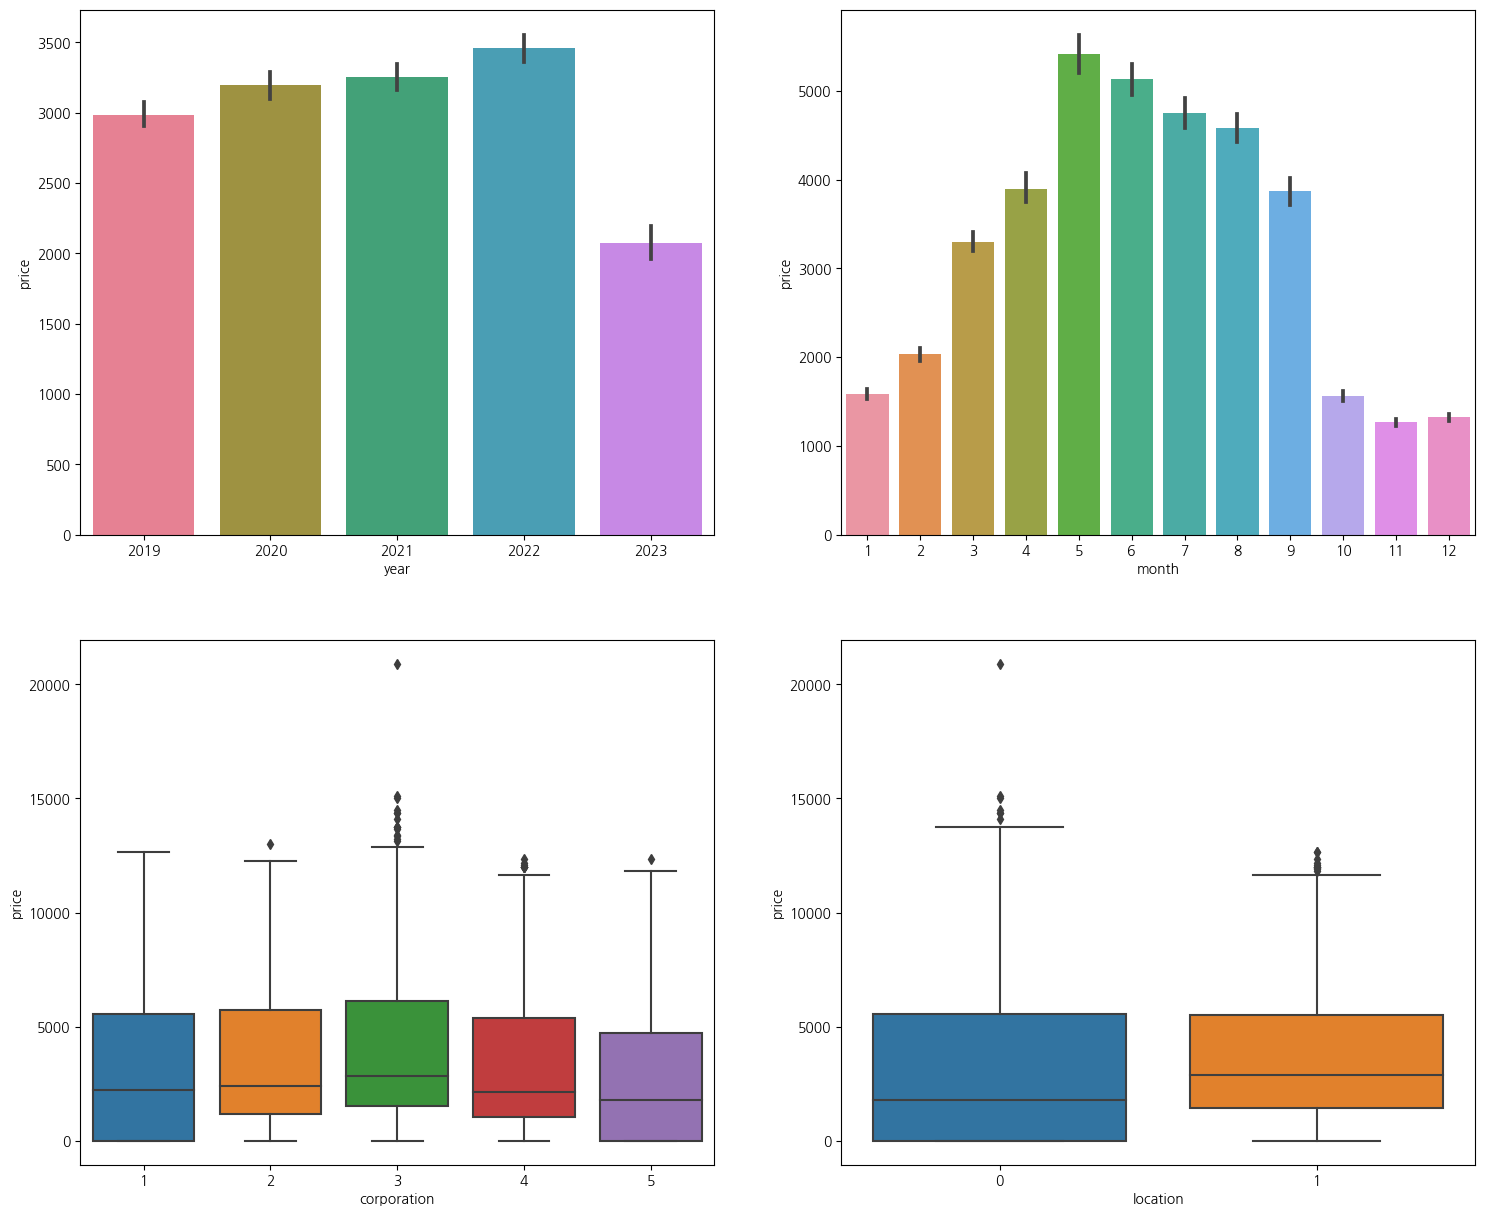

In [14]:
graph(df_tg)

### 브로콜리

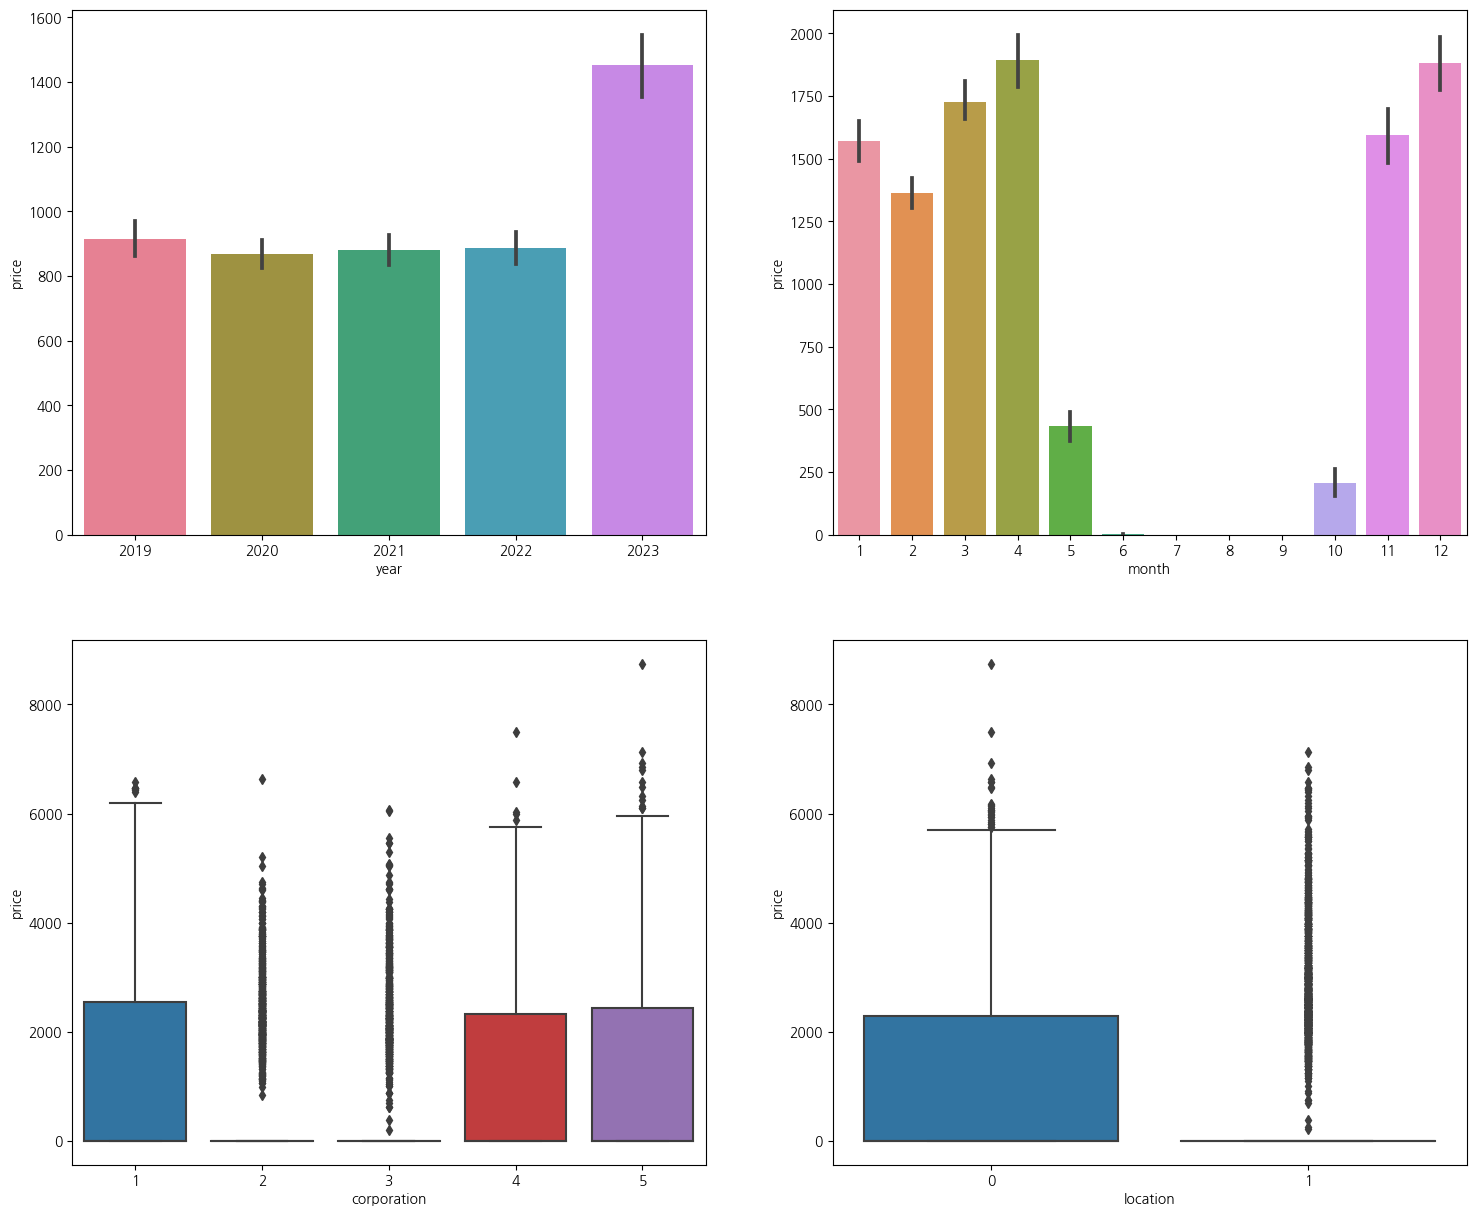

In [15]:
graph(df_bc)

### 무

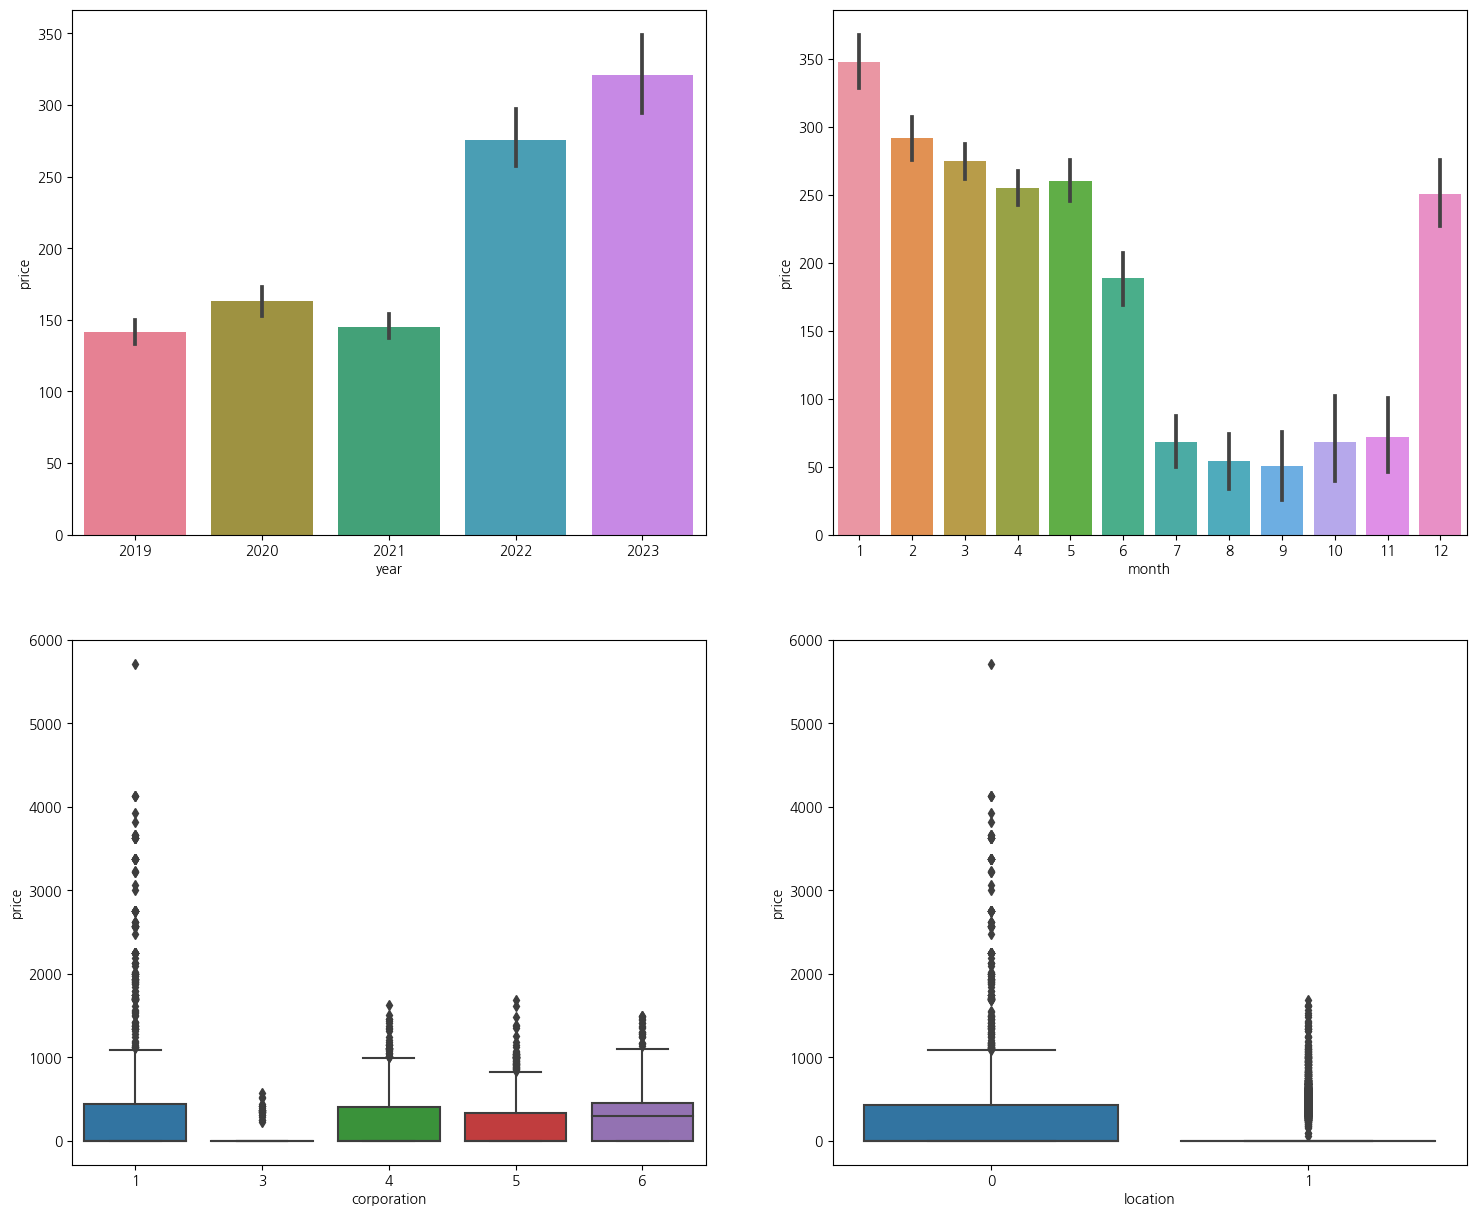

In [16]:
graph(df_rd)

### 당근

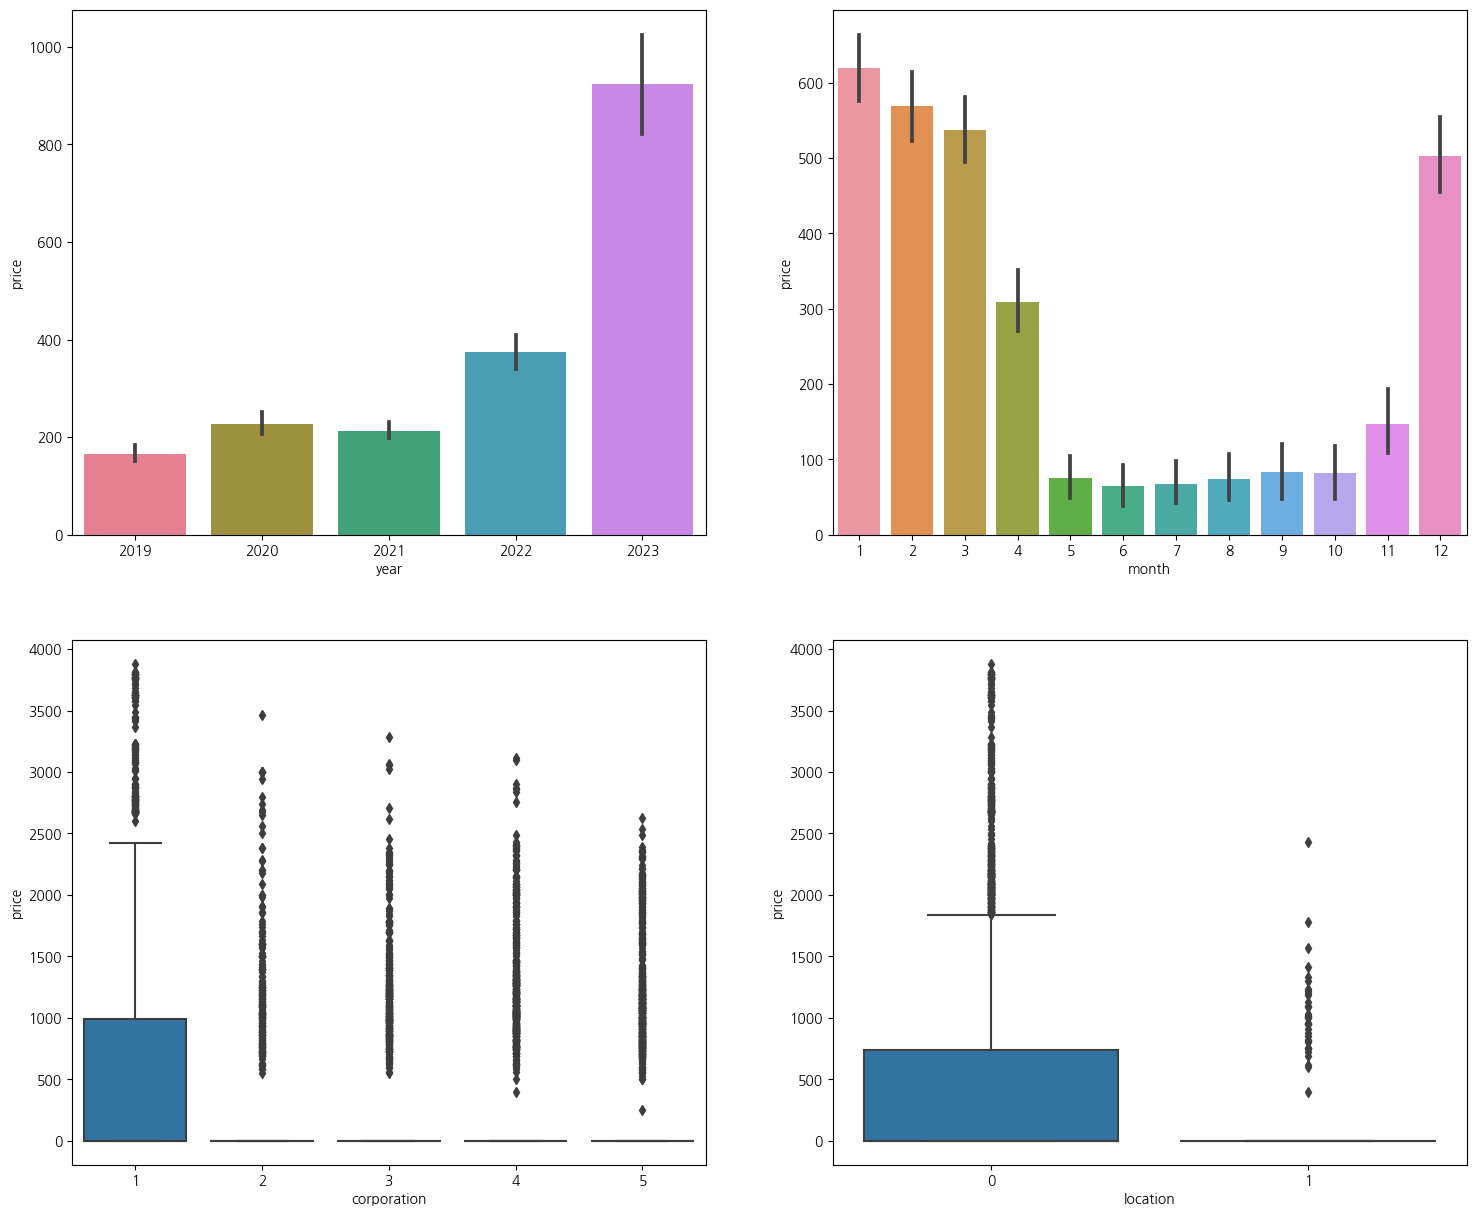

In [17]:
graph(df_cr)

### 양배추

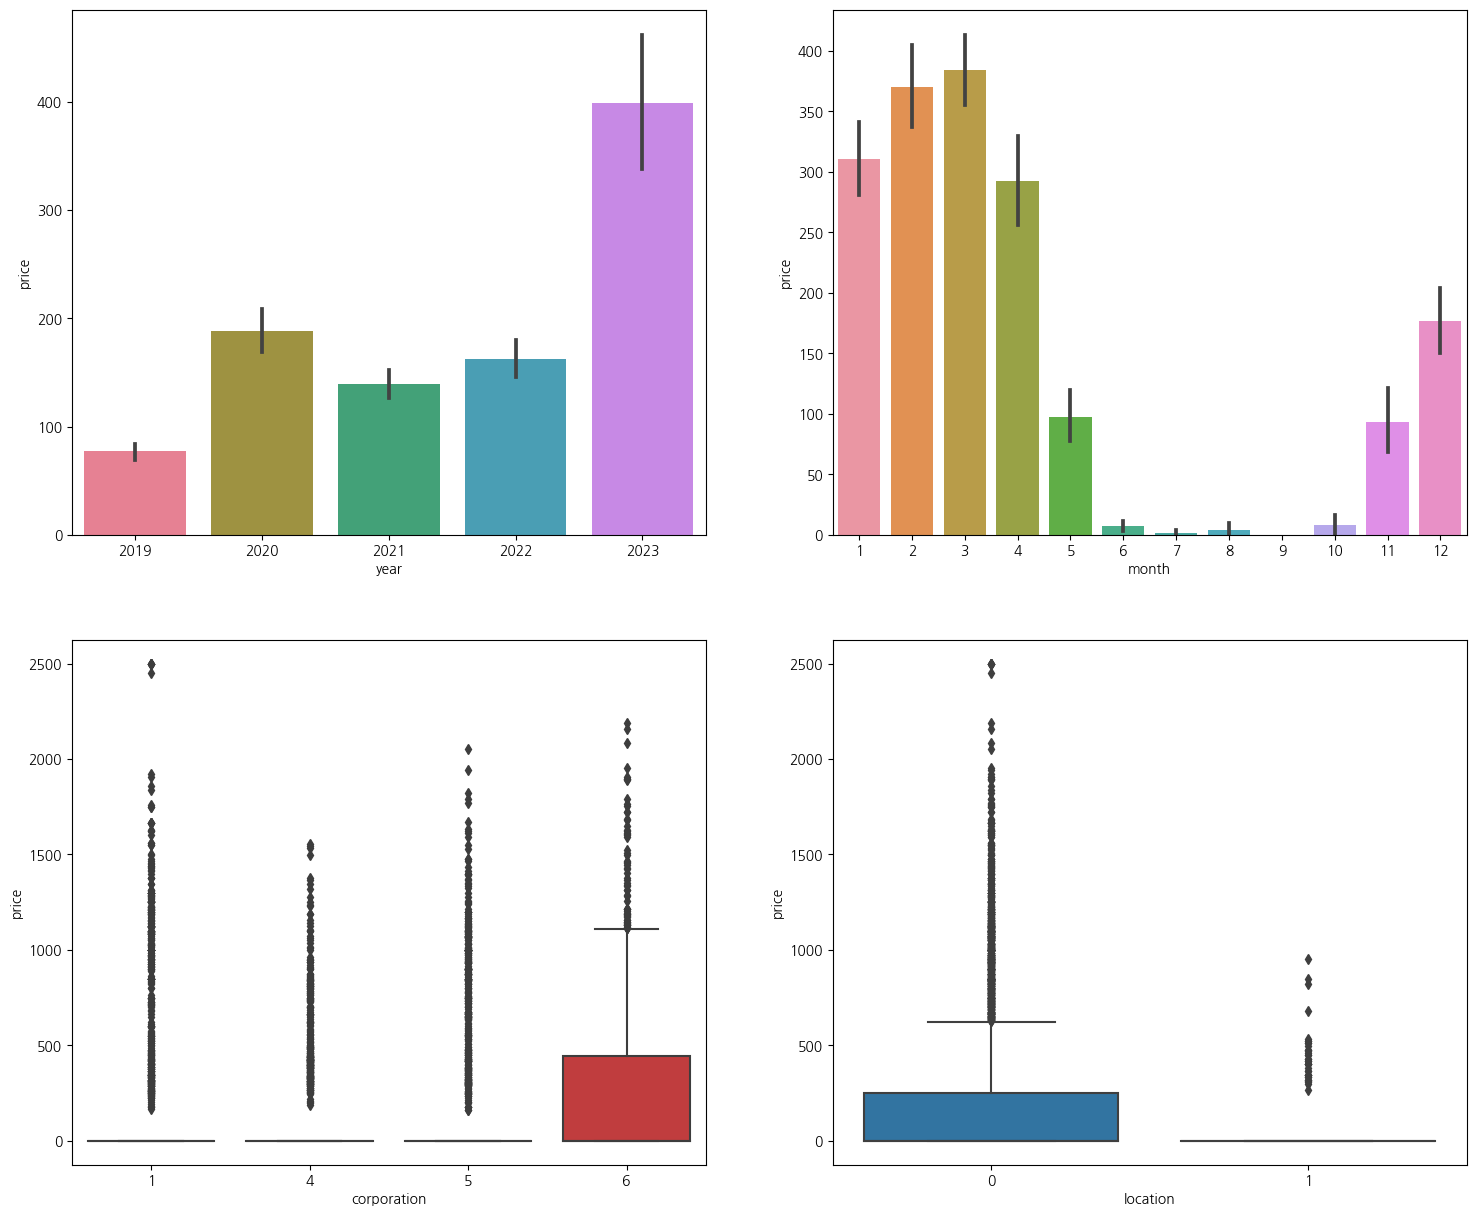

In [18]:
graph(df_cb)

# 이상치 제거
당근은 극단적인 이상치로 판단되는 값은 없는 것으로 보여 우선 다른 작물들에 대한 극 이상치만 제거해주었음

In [ ]:
tg_idx = df_tg[df_tg['price']>20000].index
bc_idx = df_bc[df_bc['price']>5000].index
rd_idx = df_rd[df_rd['price']>8000].index
cb_idx = df_cb[df_cb['price']>2300].index

df_tg.drop(tg_idx, inplace=True)
df_bc.drop(bc_idx, inplace=True)
df_rd.drop(rd_idx, inplace=True)
df_cb.drop(cb_idx, inplace=True)

# 추후 할 것
-----------------------------
- 피처 추가(필요시에 추가, 추가 안 해도 괜찮음)
- 이상치 제거
- 이외에 필요하다고 느껴지는 것
-----------------------------